In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(42)
np.random.seed(42)

os.environ["OMP_NUM_THREADS"] = "1"

step = 0.003               # Learning rate
batch_size = 32              # Number of samples for each training step
num_epochs = 50              # Number of training epochs

gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

train_all_loss=[]
train_all_acc=[]
val_all_loss=[]
val_all_acc=[]
best_accuracy=0

device = torch.device("cpu")

In [3]:
train_f=[[64, 1325, 1473, 2052, 2070, 2372, 3227, 3375, 3512, 4117, 4226, 4325, 4390, 5200, 5457, 5513, 5933, 6223, 6728, 7667, 8088, 9308, 9523, 10699, 10844, 11181, 12190, 12634, 12693, 12775, 12990, 13155, 13361, 13652, 13806, 14529, 14715, 14931, 15099, 15171, 16839, 16864, 19139, 20232, 20617, 21140, 21216, 21227, 21310, 21621, 21748, 21945, 22193, 22336, 22753, 23279, 23655, 24192, 24237, 24550, 24853, 24869, 24915, 25084, 25110, 25500, 26041, 26974, 26991, 26994, 27752, 27976, 28120, 28555, 28722, 28941, 29371, 30584, 30962, 31185, 31293, 31541, 32083, 32423, 32856, 33360, 33497, 34150, 34277, 34671, 35113, 35178, 35294, 35555, 35775, 36633, 36693, 37889, 37999, 38480, 38558, 39074, 39110, 39512, 39575, 40441, 41067, 42164, 42381, 43447, 43927, 43946, 43982, 44022, 44409, 44507, 44614, 44648, 44915, 45169, 45305, 45780, 45831, 46205, 46804, 47097, 48127, 48707, 49473, 50247, 50251, 50492, 50864, 51146, 51425, 51524, 51756, 53254, 54025, 54053, 54318, 54521, 55512, 55578, 56113, 56628, 57628, 58909, 59232, 59464], [166, 511, 1171, 1365, 2186, 2373, 2933, 2989, 3605, 3799, 3890, 4399, 4674, 4928, 5113, 6043, 6075, 6468, 6837, 7174, 7186, 7497, 7592, 7893, 8980, 9779, 9830, 10360, 10573, 10681, 11485, 11751, 13033, 13495, 13951, 14690, 14918, 15285, 15525, 15583, 15697, 15849, 15967, 16404, 16635, 17447, 18498, 18710, 19009, 19095, 19272, 19363, 20502, 20637, 21264, 21295, 21331, 21925, 22313, 22894, 23750, 24024, 24281, 24362, 24850, 25233, 25485, 25745, 25759, 25894, 26678, 26813, 27209, 27268, 27873, 28187, 28344, 28363, 28734, 28870, 28904, 29343, 29345, 29493, 30672, 31421, 31515, 31594, 31714, 31792, 32565, 33098, 33275, 33473, 33702, 33875, 34855, 34949, 36206, 36630, 36763, 36974, 38416, 39150, 39334, 39428, 39704, 40451, 40848, 40894, 40947, 41106, 41148, 41248, 41874, 42682, 42717, 43203, 43635, 44049, 44374, 45681, 46180, 46503, 46676, 46947, 48119, 48564, 48789, 48969, 50266, 50269, 50365, 50629, 50696, 50849, 50956, 51719, 52331, 54345, 54985, 55137, 55760, 57086, 57655, 58021, 59006, 59613, 59754, 59815], [92, 262, 580, 883, 1100, 1319, 1946, 2061, 2657, 3180, 3833, 5352, 5384, 5716, 5773, 6167, 6301, 6368, 7098, 7311, 7505, 8246, 8565, 9765, 10275, 10766, 11439, 12419, 13287, 13422, 13467, 13603, 14219, 14430, 14473, 14652, 15145, 15953, 17143, 17415, 19157, 19339, 19487, 19849, 19925, 20241, 20300, 20800, 22545, 22817, 22913, 23554, 23694, 24624, 24885, 25689, 26224, 28218, 28441, 28786, 28845, 28919, 29226, 29331, 29430, 29933, 29965, 30208, 31378, 31488, 31738, 31848, 32445, 32890, 32909, 33647, 33837, 34019, 35199, 35458, 35612, 35728, 36845, 37329, 37981, 38680, 38951, 39632, 39793, 40513, 41023, 41058, 41274, 41488, 42073, 42374, 42736, 42791, 43197, 43665, 43861, 44082, 44187, 44288, 44698, 45156, 45510, 45541, 45770, 46004, 46028, 47029, 47210, 47427, 47460, 47664, 47854, 48226, 48470, 48594, 48936, 49118, 49426, 49540, 49932, 49962, 50773, 50875, 51141, 51924, 52977, 53362, 53914, 53971, 54287, 54672, 54743, 54776, 55026, 55569, 55669, 55875, 56032, 57228, 57298, 57595, 58264, 58374, 59761, 59953], [374, 375, 1449, 1620, 2538, 3493, 3970, 4733, 4797, 5818, 6755, 6854, 7456, 7502, 7620, 8228, 8509, 8577, 9550, 10415, 10943, 11535, 11919, 11953, 12414, 12739, 12863, 13408, 13910, 14005, 14078, 14611, 14761, 14789, 15356, 15386, 15411, 16819, 17588, 17823, 17950, 18410, 18650, 18767, 20063, 20198, 20345, 20446, 21933, 22033, 22286, 22777, 22792, 23897, 23934, 24269, 25119, 25195, 25370, 27029, 27352, 29081, 29186, 29288, 29492, 29553, 29973, 29995, 30690, 31676, 32294, 32356, 32462, 33164, 33361, 33501, 33810, 33862, 34172, 34805, 35038, 36031, 36184, 36794, 36955, 36958, 37170, 37526, 37537, 37880, 37940, 37994, 38638, 38822, 39011, 39098, 39266, 39321, 39968, 39973, 39980, 40083, 40332, 40584, 40595, 40639, 41182, 41940, 42536, 45020, 45114, 45177, 45188, 45283, 45625, 45934, 45961, 45992, 46210, 46605, 47192, 47744, 50028, 50279, 51195, 51969, 52017, 52032, 52082, 52276, 52637, 53198, 54539, 54559, 54659, 54951, 55374, 55587, 55789, 56427, 56705, 56875, 57139, 57185, 58550, 58798, 59579, 59777, 59862, 59910], [399, 677, 842, 1090, 1152, 1425, 1917, 2241, 2501, 3036, 4545, 4828, 5394, 5496, 5725, 5757, 7637, 7919, 8534, 8625, 9239, 9645, 10670, 11359, 11617, 11874, 11993, 12041, 12092, 12793, 13322, 13555, 13583, 13770, 13844, 13971, 14070, 14096, 14679, 14731, 15262, 16618, 16706, 17416, 17693, 18728, 19154, 19415, 19955, 19988, 20009, 20561, 20707, 21141, 21575, 21616, 22180, 22233, 22746, 22885, 23326, 23690, 23758, 24039, 24662, 24880, 25038, 25112, 25953, 25998, 27035, 27077, 27350, 27533, 27844, 29598, 29654, 30230, 30616, 31301, 32016, 32107, 33265, 33591, 34024, 34333, 35379, 35501, 35562, 35692, 35760, 36146, 36965, 38112, 38895, 39449, 39578, 39913, 40157, 40436, 40485, 40736, 41538, 41561, 42601, 42881, 43393, 43423, 45231, 45297, 45739, 46115, 47193, 47465, 47472, 47780, 47919, 47968, 48066, 48323, 48583, 48716, 48727, 48794, 48865, 49717, 49853, 50559, 51320, 51465, 51916, 52557, 52979, 53398, 54589, 54762, 55217, 55283, 55826, 55907, 56562, 56783, 56978, 57166, 57558, 58611, 59531, 59564, 59575, 59963], [192, 227, 2030, 2092, 2721, 2819, 2956, 3916, 4181, 5213, 5232, 5660, 5898, 6232, 6579, 6811, 6931, 7074, 9173, 9676, 9728, 9947, 10393, 10486, 10575, 12043, 13974, 14222, 14346, 14651, 14991, 15212, 15696, 16218, 16302, 16876, 17487, 18130, 18513, 18522, 18754, 18783, 20498, 20519, 20646, 20777, 21167, 22234, 22277, 22310, 22346, 22363, 22485, 23071, 23797, 24252, 24937, 25884, 26044, 27101, 27147, 28129, 28380, 29033, 29191, 29285, 29399, 29626, 29881, 30637, 31162, 32240, 32376, 32487, 32724, 33069, 33662, 33733, 33879, 34651, 34944, 35296, 35423, 35689, 35803, 36088, 36196, 36268, 36653, 36666, 36687, 36874, 38182, 38318, 38492, 38504, 38733, 38908, 39860, 40398, 40519, 40720, 40726, 40805, 41445, 42906, 43284, 43470, 43780, 43845, 44477, 44538, 45295, 45577, 46512, 46760, 48000, 48194, 48235, 48742, 49494, 49606, 49825, 49971, 50394, 50683, 50724, 51037, 51161, 51280, 51684, 51760, 51888, 51988, 52016, 52568, 53669, 54696, 55383, 56233, 56419, 57246, 57279, 57660, 57796, 57959, 59437, 59446, 59542, 59600], [875, 1096, 1732, 1830, 2774, 3204, 3293, 3786, 4046, 4422, 5376, 5564, 5739, 5748, 6126, 6183, 6392, 6955, 6983, 7432, 7869, 8184, 8327, 8844, 8898, 9042, 9811, 9860, 9954, 10471, 10995, 11697, 11698, 12025, 12127, 12192, 12745, 13148, 13851, 14204, 14401, 14418, 15236, 16030, 16066, 16733, 18064, 18343, 18404, 18441, 18579, 18851, 19382, 19598, 20012, 20180, 20308, 20395, 21090, 21460, 22108, 22976, 22997, 23464, 24064, 24542, 24654, 25646, 25766, 26098, 26529, 27163, 27424, 28173, 28478, 28516, 28805, 29140, 29443, 29572, 29678, 30058, 30360, 31219, 31467, 31525, 31762, 32066, 32221, 33612, 34619, 35072, 35473, 36049, 36770, 37339, 38577, 38815, 40077, 40124, 40358, 40381, 40629, 41123, 41363, 41553, 41719, 41915, 42630, 42709, 42738, 42750, 43025, 43133, 43176, 44835, 45226, 45606, 46377, 47660, 47910, 48182, 48699, 51114, 51382, 51799, 52119, 52472, 52807, 53208, 53425, 53621, 53841, 53863, 54189, 55033, 55498, 55557, 56076, 56127, 56177, 56702, 56811, 56958, 57519, 58012, 58316, 58885, 59020, 59124], [41, 131, 369, 547, 668, 1297, 1422, 1826, 2321, 2903, 3713, 3836, 3908, 4174, 4708, 4995, 6147, 6177, 7072, 7185, 8555, 8673, 8741, 9590, 9776, 11401, 12184, 12194, 12401, 13030, 13489, 13863, 14082, 14220, 14302, 15135, 15158, 15869, 15920, 16757, 16845, 17017, 17393, 17530, 17872, 18119, 18138, 18508, 18577, 18763, 18822, 18993, 19431, 20132, 20230, 20547, 21847, 22257, 22522, 22683, 23039, 23261, 23540, 24173, 24292, 24975, 24979, 26347, 26490, 26740, 27401, 27620, 28650, 28966, 29156, 29615, 30458, 30817, 30841, 31237, 31648, 31658, 31975, 32293, 32825, 33059, 33104, 33479, 34470, 34890, 35020, 35036, 35193, 35682, 35901, 37024, 37042, 37991, 38073, 38349, 38495, 39018, 39524, 39565, 40203, 40230, 40354, 42145, 42593, 42873, 42880, 42936, 43580, 43658, 45502, 45505, 45517, 45773, 46404, 46569, 47600, 47607, 49586, 49609, 49650, 50191, 50241, 50453, 50583, 50590, 50824, 51226, 51229, 51583, 51978, 52428, 52565, 52918, 53140, 54239, 54475, 54907, 55179, 55458, 56405, 57407, 58017, 58050, 58108, 58468], [148, 408, 528, 736, 1095, 1524, 1759, 2054, 2986, 3103, 3594, 3834, 6199, 6276, 6289, 7146, 7313, 7338, 7527, 7532, 7641, 7866, 8013, 8454, 9650, 9982, 10252, 10279, 10987, 11959, 12245, 12641, 12746, 12910, 13035, 13291, 13506, 13759, 14366, 15985, 16134, 16955, 17056, 17141, 17230, 17655, 18019, 18359, 19190, 19755, 19759, 20332, 20361, 20416, 20805, 21574, 23178, 23250, 23353, 23399, 23859, 24811, 25114, 25202, 25206, 25316, 25655, 26012, 26286, 26381, 26520, 26787, 27116, 29621, 29809, 30455, 32750, 33074, 34605, 34654, 34785, 34803, 34981, 35343, 35504, 35665, 35857, 35916, 35974, 36850, 37011, 37489, 37539, 37651, 37665, 38046, 38125, 38448, 38475, 38540, 38660, 39166, 39390, 39902, 40130, 40324, 40860, 41082, 41455, 41909, 42614, 43066, 43473, 43561, 45101, 46318, 46427, 46815, 47004, 47220, 48783, 49446, 49531, 49958, 50040, 50410, 50978, 51903, 51942, 52921, 53497, 53929, 54200, 55145, 55243, 55306, 55924, 56411, 56586, 56747, 57575, 57872, 58011, 58500, 58581, 59017, 59095, 59146, 59415, 59562], [198, 643, 651, 1546, 2465, 3632, 4393, 4578, 5057, 5122, 5589, 6454, 6455, 6528, 7287, 7353, 7455, 8069, 8264, 8598, 8617, 8690, 9701, 10056, 10319, 10550, 10918, 11146, 11186, 11540, 11849, 11883, 13469, 13647, 13664, 13744, 13817, 14053, 14121, 14151, 17147, 17535, 18608, 19084, 19089, 19098, 19174, 19300, 20281, 20578, 21083, 21254, 21558, 22003, 22052, 22091, 23021, 24536, 24864, 25008, 25356, 25697, 25729, 26857, 26995, 27131, 27381, 28326, 28374, 29087, 29359, 29488, 30972, 31486, 31610, 31763, 32053, 32147, 32158, 32808, 33968, 34718, 35104, 35229, 35319, 35727, 35868, 36270, 36327, 36496, 36689, 37294, 37681, 38546, 38630, 38985, 39228, 39687, 40177, 40200, 40399, 41433, 41602, 41865, 42148, 42284, 42964, 43064, 43340, 43957, 44408, 45876, 46378, 46407, 46441, 47047, 47265, 47444, 47909, 47948, 48693, 48906, 48946, 49575, 49755, 49934, 50068, 50470, 50521, 51028, 51091, 51186, 51679, 51928, 52478, 53640, 54187, 54592, 54913, 54997, 55777, 56485, 57130, 57644, 58360, 58602, 58803, 59337, 59878, 59932]]
valid_f=[[6757, 7125, 9007, 10873, 11256, 12275, 15306, 16720, 17737, 18558, 21862, 23332, 25251, 25929, 27908, 28461, 29998, 30249, 31529, 32112, 34134, 35676, 36092, 36168, 40180, 40568, 40680, 40840, 41416, 42436, 42553, 45109, 46410, 47926, 48261, 50722, 51753, 51921, 52055, 52532, 52857, 53068, 54027, 54077, 54603, 55294, 55868, 56205, 57453, 57986], [143, 1499, 1509, 2701, 3918, 4697, 5370, 6185, 6318, 6346, 6734, 8903, 9078, 10839, 11008, 11138, 13534, 14093, 19750, 21726, 22770, 23134, 23685, 24300, 24593, 24647, 25808, 27548, 28096, 28408, 30228, 30425, 33948, 34255, 36204, 39775, 44415, 45180, 48743, 49796, 49897, 50447, 51151, 51929, 54046, 55391, 56101, 56580, 57017, 57094], [574, 1279, 3884, 4069, 4414, 4445, 5843, 7569, 11310, 12389, 12898, 14142, 16755, 18627, 19106, 19543, 21382, 21645, 23637, 25791, 25838, 25993, 26445, 26940, 31934, 33020, 33422, 34015, 35052, 37279, 38458, 39833, 40086, 40205, 41486, 42978, 43086, 45010, 45619, 45719, 47924, 49247, 49713, 50704, 51617, 52927, 53877, 54479, 59305, 59964], [961, 2285, 2800, 4025, 4144, 4698, 5121, 5212, 5845, 6140, 8290, 8967, 10492, 10841, 12827, 13981, 14975, 15492, 15538, 16177, 17587, 18572, 22082, 22628, 24895, 25018, 25303, 25346, 25371, 28481, 28513, 31851, 32607, 34554, 35649, 37415, 38001, 38307, 39077, 39083, 44202, 45348, 46421, 47030, 49503, 54665, 54671, 54991, 55976, 57716], [2098, 2162, 2264, 2513, 4247, 7659, 8526, 8624, 10796, 11042, 12399, 15328, 16698, 18877, 22122, 22161, 24629, 24739, 25250, 29316, 31490, 33316, 33417, 33592, 34016, 35789, 35967, 38879, 39651, 39987, 40153, 42084, 42170, 44535, 46093, 46232, 47140, 50130, 50451, 52052, 52183, 54437, 54953, 55254, 57192, 57233, 57656, 58730, 58754, 59541], [2908, 4302, 5558, 5819, 7746, 7821, 8446, 8579, 9866, 11490, 12140, 13418, 14426, 14534, 15993, 18842, 19017, 20982, 22408, 23118, 23375, 25218, 25317, 25508, 25967, 27897, 29923, 32590, 33385, 34051, 35023, 35243, 37675, 37759, 39100, 39331, 40318, 41232, 41586, 43753, 45069, 45413, 47327, 48068, 50874, 51003, 56288, 57620, 58116, 58601], [762, 1626, 3077, 4031, 4232, 4294, 6377, 7210, 10086, 11152, 11572, 11619, 11870, 13004, 14923, 16967, 19358, 19380, 22986, 23947, 24638, 25585, 28630, 31659, 32775, 32807, 32943, 33298, 35877, 36604, 41642, 41701, 41762, 42056, 42900, 46379, 46710, 47116, 47385, 48573, 49195, 49410, 49733, 50816, 51237, 52014, 55455, 55740, 58046, 58870], [1075, 2269, 2895, 3206, 3515, 3687, 4549, 4843, 5718, 5727, 5949, 8684, 9439, 11455, 11914, 12396, 13209, 14258, 14353, 14674, 14719, 14977, 16693, 18120, 20480, 20511, 20523, 21983, 24199, 26456, 27598, 28676, 29369, 31756, 32192, 32224, 32614, 33078, 34622, 38344, 38402, 38464, 38884, 39677, 46482, 49927, 51589, 53241, 56280, 58233], [4175, 4335, 4408, 5678, 6000, 6099, 6856, 6977, 8954, 9804, 10197, 12297, 14799, 15215, 15405, 17286, 18734, 18867, 19587, 19795, 21427, 23208, 23948, 24700, 25703, 27422, 29448, 29754, 35547, 35722, 36487, 36587, 36981, 38018, 38310, 38599, 42032, 46491, 46827, 47035, 50437, 52399, 53096, 53761, 54142, 57176, 57443, 58430, 58927, 59165], [450, 3593, 4326, 4385, 4986, 5731, 8533, 11013, 11307, 11320, 12712, 13870, 14209, 15309, 15524, 15949, 18395, 18507, 18511, 21627, 22477, 22747, 24793, 28679, 29872, 30263, 31077, 33353, 33696, 36165, 38443, 40596, 42373, 43466, 44760, 45316, 45460, 45555, 47648, 47723, 49227, 49734, 51086, 51148, 52732, 56030, 57860, 58903, 58982, 59059]]
test_f=[[113, 155, 488, 501, 889, 1249, 1802, 2149, 2218, 2264, 2277, 2279, 2452, 2653, 2673, 2878, 3055, 3306, 3371, 3466, 3531, 3754, 3953, 4018, 4042, 4340, 4522, 4625, 4628, 5030, 5209, 5221, 5745, 6308, 6432, 6654, 6679, 6808, 6953, 7127, 7266, 7280, 7456, 7687, 7803, 8233, 8779, 9349, 9577, 9719], [15, 173, 409, 519, 1182, 1208, 1880, 1990, 2088, 2169, 2254, 2386, 2468, 2925, 2994, 3321, 3412, 3475, 3627, 3650, 3778, 4202, 4457, 4470, 4725, 5327, 5588, 5845, 6167, 6265, 6343, 6580, 6656, 7185, 7329, 7438, 7487, 7636, 8105, 8563, 9037, 9065, 9209, 9244, 9532, 9635, 9647, 9763, 9799, 9850], [54, 55, 172, 243, 1061, 1191, 1204, 1267, 1655, 1743, 1949, 2548, 2646, 2868, 2964, 3255, 3288, 3457, 3534, 3939, 3985, 4037, 4230, 4847, 4943, 5493, 5557, 5578, 5619, 5725, 5751, 5804, 5852, 6086, 6089, 6146, 6229, 6633, 6826, 7288, 7301, 7327, 7603, 7976, 8384, 8877, 8992, 9276, 9300, 9387], [33, 694, 871, 1044, 1150, 1282, 1565, 1634, 1687, 1952, 2128, 2151, 2347, 2721, 2900, 3050, 3403, 3463, 3476, 3722, 3802, 4928, 5179, 5692, 5848, 5931, 6012, 6140, 6182, 6186, 6280, 6353, 6429, 6584, 7088, 7551, 7565, 7576, 7799, 7934, 8003, 8097, 8377, 8469, 8513, 9042, 9159, 9522, 9667, 9771], [313, 404, 425, 433, 571, 805, 875, 1055, 1178, 1298, 2015, 2150, 2467, 2676, 2705, 2873, 3325, 3614, 4289, 4489, 4797, 4995, 5120, 5138, 5173, 5183, 5492, 5669, 5919, 6200, 6234, 6513, 6561, 6601, 6818, 6829, 6922, 6994, 7383, 7914, 7956, 8283, 8470, 8960, 9054, 9062, 9231, 9348, 9477, 9496], [21, 52, 111, 542, 592, 658, 676, 819, 1011, 1240, 1453, 1563, 1727, 1799, 1819, 2183, 2265, 2535, 2672, 2773, 3063, 3411, 3883, 4208, 4576, 4707, 4811, 5733, 5882, 6194, 6550, 6827, 7027, 7235, 7279, 7741, 7754, 7833, 8182, 8422, 8533, 8575, 8719, 9113, 9268, 9467, 9520, 9606, 9742, 9827], [389, 411, 587, 734, 860, 968, 989, 1004, 1025, 1620, 1725, 1771, 1796, 2191, 2927, 3203, 3232, 3327, 3347, 3724, 3876, 4088, 4153, 4642, 4896, 5155, 5475, 5873, 6127, 6540, 6582, 6870, 6996, 7004, 7222, 7903, 8106, 8306, 8403, 8523, 8622, 8651, 8674, 8728, 9284, 9360, 9402, 9416, 9423, 9859], [22, 104, 160, 278, 824, 853, 999, 1750, 1772, 1866, 1869, 2100, 2294, 2772, 2883, 3136, 3166, 3185, 3222, 3355, 3494, 3507, 3573, 3788, 3812, 3949, 4558, 5054, 5500, 5769, 5915, 5920, 6247, 6397, 6475, 6541, 6609, 6612, 6910, 6968, 7554, 7728, 7845, 8108, 8514, 8808, 8831, 8865, 9012, 9905], [58, 427, 469, 486, 533, 802, 983, 1171, 1525, 1551, 1555, 1616, 1979, 2282, 2720, 3091, 3366, 3743, 3774, 3869, 4107, 4309, 4312, 4463, 4524, 4640, 5115, 5277, 5537, 5942, 6067, 6084, 6142, 6529, 6619, 6630, 6665, 6975, 6978, 7152, 7479, 7622, 8062, 8119, 8143, 8171, 8544, 8965, 9642, 9903], [401, 756, 892, 1522, 1594, 2135, 2210, 2214, 2525, 2559, 2711, 3368, 3381, 3505, 3832, 4014, 4273, 5033, 5069, 5279, 5788, 6047, 6054, 6079, 6166, 6659, 6998, 7062, 7148, 7171, 7309, 7316, 7457, 7472, 7530, 7871, 8124, 8192, 8401, 8711, 8767, 8854, 8932, 8977, 9047, 9080, 9121, 9304, 9569, 9649]]


In [4]:
# 预处理
my_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

# 载入训练集
train_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=True, 
    transform=my_transform,
    download=True
)
# 生成测试集
test_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=False, 
    transform=my_transform,
    download=True
)
# 生成验证集
val_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=False, 
    transform=my_transform,
    download=True
)
train_data = train_dataset.data
train_targets = train_dataset.targets
val_data = val_dataset.data
val_targets = val_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

train_d_c = torch.zeros([1500, 28,28], dtype=torch.uint8)
train_t_c = torch.zeros([1500])
all_1=0

val_d_c = torch.zeros([500, 28,28], dtype=torch.uint8)
val_t_c = torch.zeros([500])
all_2=0

for i in range(60000):
    if i in train_f[train_targets[i]]:
        train_t_c[all_1]=train_targets[i]
        train_d_c[all_1]=train_data[i]
        all_1=all_1+1
    if i in valid_f[train_targets[i]]:
        val_t_c[all_2]=train_targets[i]
        val_d_c[all_2]=train_data[i]
        all_2=all_2+1


test_d_c = torch.zeros([500, 28,28], dtype=torch.uint8)
test_t_c = torch.zeros([500])
all_3=0

for i in range(10000):
    if i in test_f[test_targets[i]]:
        test_t_c[all_3]=test_targets[i]
        test_d_c[all_3]=test_data[i]
        all_3=all_3+1
        
train_dataset.data = train_d_c
train_dataset.targets = train_t_c
val_dataset.data = val_d_c
val_dataset.targets = val_t_c
test_dataset.data = test_d_c
test_dataset.targets = test_t_c

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)
print(train_data_size)
print(valid_data_size)
print(test_data_size)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

1500
500
500


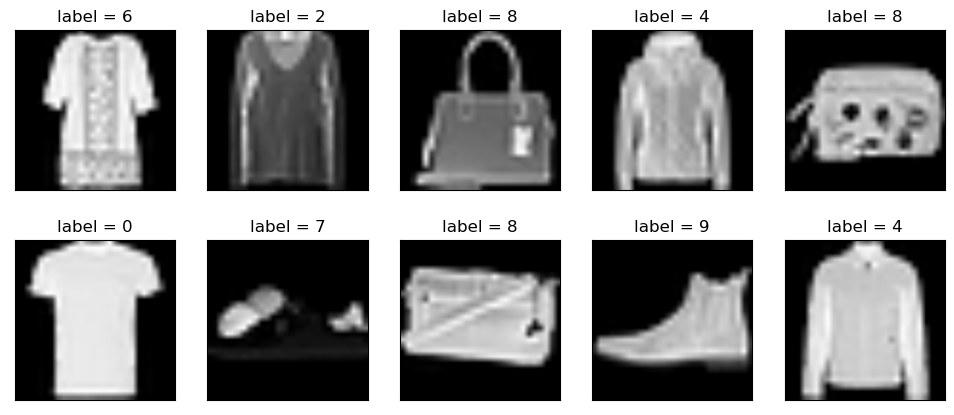

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
import random
from matplotlib import pyplot as plt
def denorm(img):
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    return img
plt.figure(figsize=(12, 5))
for i in range(10):
    img, label = train_dataset[random.randint(0, len(train_dataset))]
#     print(img.size())
    img = denorm(img)
    img = img.permute(1, 2, 0)
    ax = plt.subplot(2, 5, i + 1)
#     plt.imshow(img.squeeze(0), cmap='gray', interpolation='none')
    ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


In [6]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, 256)
        
        self.c1 = nn.Conv1d(1, 3, 5)
        self.s2 = nn.MaxPool1d(7)
        
        self.c3 = nn.Conv1d(3, 1, 5)
        self.s4 = nn.MaxPool1d(7)
        
        self.relu = nn.ReLU()
                
        self.output = nn.Linear(4, 10)
    def forward(self, x):
        bath_s=x.size(0)
        x = self.flatten(x)
        x = self.fc(x)
        x=x.view(bath_s,1,256)
        x = self.relu(self.c1(x))
        x = self.s2(x)
        x = self.relu(self.c3(x))
        x = self.s4(x)
        x = self.flatten(x)
        x = self.output(x)
        return x


In [7]:
model_hybrid = torchvision.models.resnet18(pretrained=True)
for param in model_hybrid.parameters():
    param.requires_grad = False
model_hybrid.fc = CNN_1D()

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step, weight_decay=0.0001)


D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_model(model, criterion, optimizer, num_epochs):

    print("Training started:")

    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i,(inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            # print(ret)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            y_true=[]
            y_pred=[]
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predictions.cpu().numpy().tolist())

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model, 'Result/TL-CNN_1D_Fashion-MNIST_2500.pth')


        epoch_end = time.time()

        print(
            "\t Training: Loss: {:.4f}, Accuracy: {:.4f}%, "
            "\n\t Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.3f}s".format(
                avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100,
                                epoch_end - epoch_start
            ))
        print("\t Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        train_all_loss.append(avg_train_loss)
        train_all_acc.append(avg_train_acc)
        val_all_loss.append(avg_valid_loss)
        val_all_acc.append(avg_valid_acc)
        best_accuracy=best_acc

In [9]:
train_model(model_hybrid, criterion, optimizer_hybrid, num_epochs)

Training started:
Epoch: 1/50
	 Training: Loss: 2.1764, Accuracy: 10.0000%, 
	 Validation: Loss: 2.1542, Accuracy: 10.0000%, Time: 90.176s
	 Best Accuracy for validation : 0.1000 at epoch 001
Epoch: 2/50
	 Training: Loss: 2.0044, Accuracy: 18.9333%, 
	 Validation: Loss: 1.9586, Accuracy: 22.2000%, Time: 106.647s
	 Best Accuracy for validation : 0.2220 at epoch 002
Epoch: 3/50
	 Training: Loss: 1.9308, Accuracy: 22.2000%, 
	 Validation: Loss: 1.8796, Accuracy: 23.6000%, Time: 107.339s
	 Best Accuracy for validation : 0.2360 at epoch 003
Epoch: 4/50
	 Training: Loss: 1.8680, Accuracy: 24.5333%, 
	 Validation: Loss: 1.9207, Accuracy: 25.8000%, Time: 106.307s
	 Best Accuracy for validation : 0.2580 at epoch 004
Epoch: 5/50
	 Training: Loss: 1.8126, Accuracy: 31.3333%, 
	 Validation: Loss: 1.6897, Accuracy: 32.0000%, Time: 104.432s
	 Best Accuracy for validation : 0.3200 at epoch 005
Epoch: 6/50
	 Training: Loss: 1.6561, Accuracy: 33.0667%, 
	 Validation: Loss: 1.6060, Accuracy: 32.6000%, T

	 Training: Loss: 0.3932, Accuracy: 87.9333%, 
	 Validation: Loss: 0.7950, Accuracy: 74.6000%, Time: 95.947s
	 Best Accuracy for validation : 0.7700 at epoch 040
Epoch: 49/50
	 Training: Loss: 0.3316, Accuracy: 88.0000%, 
	 Validation: Loss: 0.7111, Accuracy: 78.2000%, Time: 67.457s
	 Best Accuracy for validation : 0.7820 at epoch 049
Epoch: 50/50
	 Training: Loss: 0.3457, Accuracy: 87.8667%, 
	 Validation: Loss: 0.7178, Accuracy: 76.8000%, Time: 68.321s
	 Best Accuracy for validation : 0.7820 at epoch 049


In [10]:
print(train_all_loss)
print(train_all_acc)
print(val_all_loss)
print(val_all_acc)


[2.176394223531087, 2.0043777017593385, 1.9307916889190673, 1.868048976580302, 1.8125815814336141, 1.6561002670923868, 1.593622021039327, 1.5370731334686278, 1.4467872091929117, 1.4256693855921427, 1.2822972857157389, 1.1064068581263224, 1.0335251398086547, 0.9878285204569499, 0.9429410676956177, 0.8718520533243815, 0.874933139483134, 0.8782258041699728, 0.8023386980692545, 0.7434456427892049, 0.7120951846440633, 0.6582853269577026, 0.6892587835788727, 0.7584339475631714, 0.6540561964511872, 0.654149941444397, 0.6314557967185974, 0.6012356052398682, 0.6376334957281748, 0.528132247765859, 0.5307242048581441, 0.561732278029124, 0.5572074263890584, 0.5281193064053853, 0.5102582314809163, 0.4739622639020284, 0.4500837213198344, 0.47148581107457477, 0.43729957882563275, 0.4004171625773112, 0.4203778793811798, 0.43929258624712625, 0.4001352683703105, 0.3521358165740967, 0.37868005855878195, 0.49980044571558635, 0.4007559116681417, 0.393183730840683, 0.3315772852897644, 0.34574845417340594]
[

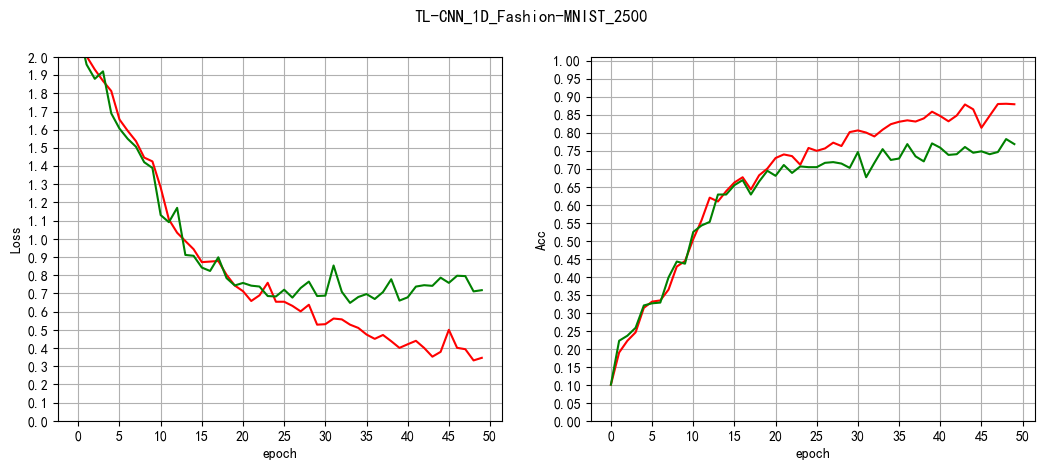

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

x = np.arange(0, 50)

width, height = 32, 12 
fig = plt.figure()
fig.suptitle("TL-CNN_1D_Fashion-MNIST_2500", fontsize=12)

fig.set_size_inches(width / 2.54, height / 2.54)

plt.subplot(1, 2, 1)  # fig.1是一个一行两列布局的图，且现在画的是左图
loss_1 = train_all_loss
loss_2 = val_all_loss
line1, = plt.plot(x, loss_1, color='r')
line2, = plt.plot(x, loss_2, color='g')
# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 2.0001, 0.1))
plt.ylim(0, 2)


plt.subplot(1, 2, 2)  # 当前图变为fig.1的右图
acc_1 = train_all_acc
acc_2 = val_all_acc

line1, = plt.plot(x, acc_1, color='r')
line2, = plt.plot(x, acc_2, color='g')

# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Acc")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0.0, 1.01, 0.05))
plt.ylim(0.0, 1.01)

plt.show()


In [12]:
model_Q = torch.load('Result/TL-CNN_1D_Fashion-MNIST_2500.pth', map_location=device)
model_Q.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
print('TL-CNN_1D_Fashion-MNIST_2500')

totel_acc=0.0

for j, (inputs, labels) in enumerate(test_dataloader):
    outputs = model_Q(inputs)
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    totel_acc += acc.item() * inputs.size(0)
print('测试集500：')
print(totel_acc/test_data_size)

TL-CNN_1D_Fashion-MNIST_2500
测试集500：
0.782
